# Manta ray annotations in COCO format

In [1]:
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os
import shutil
import imageio as io
import json
import numpy as np
from glob import glob
from pathlib import Path
import cv2

%matplotlib inline

## Create manta ray annotations in COCO format from original files

Define source folders where original images and corresponding binary masks that localizes belly pattern are stored in the old folmat. Images for each individual are stored in a separate folder.

In [2]:
source_images = '/home/olga/projects_anaconda/manta_project_v2/data/0_manta_selected'
source_masks = '/home/olga/projects_anaconda/manta_project_v2/data/masks'

In [3]:
target_dir = Path('manta_ray.coco')
targetType = 'train2021'
targer_image_dir = target_dir / 'images' / targetType
targer_annot_dir = target_dir / 'annotations'
annot_filename = targer_annot_dir / 'instances_{}.json'.format(targetType)

targer_image_dir.mkdir(parents=True, exist_ok=True)
targer_annot_dir.mkdir(parents=True, exist_ok=True)

Change `debug` to `True` while experimenting.

In [4]:
debug = False

In [5]:
image_paths = glob(source_images + '/*/*')
print('Found {} image files'.format(len(image_paths)))

Found 1803 image files


In [6]:
mask_paths = glob(source_masks + '/*/*')
print('Found {} mask files'.format(len(mask_paths)))

Found 1811 mask files


In [7]:
def get_bound_box(filename):
    """Find bounding box for masked image.
    --------------------------------------
    Input:
    filename - string, path to masked image
    
    Return:
    (x,y,w,h) - tuple, bounding box
    """
    img = io.imread(filename)

    #Threshold mask
    ret,thresholded = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    #Lots of changes in return variables in function findContours
    #https://stackoverflow.com/questions/48291581/how-to-use-cv2-findcontours-in-different-opencv-versions/48292371#48292371
    contours = cv2.findContours(thresholded, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
    # Choose largest contour
    best = 0
    maxsize = 0
    count = 0
    for cnt in contours:
        if cv2.contourArea(cnt) > maxsize :
            maxsize = cv2.contourArea(cnt)
            best = count

        count = count + 1
    x,y,w,h = cv2.boundingRect(contours[best])
    return (x,y,w,h)

In [8]:
annotations = []
images = []


for idx, image_path in enumerate(image_paths):
    image_path = Path(image_path)
    name = image_path.parent.name
    image_h, image_w = io.imread(image_path).shape[:2]
    mask_path = Path(source_masks) / image_path.parent.name / image_path.name
    #x, y, w, h = get_bound_box(mask_path)
    y, x, h, w = get_bound_box(mask_path)
    
    image = {'license': 1,
             'file_name': image_path.name,
             'photographer': '',
             'coco_url': None,
             'height': image_h,
             'width': image_w,
             'date_captured': 'NA',
             'gps_lat_captured': '-1.000000',
             'gps_lon_captured': '-1.000000',
             'flickr_url': None,
             'id': idx
            }
    annot = {'bbox': [x, y, w, h],
              'theta': 'none',
              'viewpoint': 'none',
              'segmentation': [[y, x, y+h, x, y+h, x+w, y, x+w, y, x]],
              'segmentation_bbox': [x, y, w, h],
              'area': h*w,
              'iscrowd': 0,
              'id': idx,
              'image_id': idx,
              'category_id': 0,
              'individual_ids': [],
              'isinterest': 0,
              'name': name
            }
    
    images.append(image)
    annotations.append(annot)
    target_path = targer_image_dir / image_path.name
    shutil.copyfile(image_path, target_path)
    
    # Copy and save images
    
    if debug and idx > 10:
        break
        
    if idx % 100 == 0:
        print('Processed {} images'.format(idx))

Processed 0 images
Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images


In [9]:
images[0], annotations[0]

({'license': 1,
  'file_name': '32-F-20080407-LEI-MarkAtkinson-DAMIA-4.jpg',
  'photographer': '',
  'coco_url': None,
  'height': 3000,
  'width': 4000,
  'date_captured': 'NA',
  'gps_lat_captured': '-1.000000',
  'gps_lon_captured': '-1.000000',
  'flickr_url': None,
  'id': 0},
 {'bbox': [960, 1201, 1645, 2021],
  'theta': 'none',
  'viewpoint': 'none',
  'segmentation': [[1201, 960, 3222, 960, 3222, 2605, 1201, 2605, 1201, 960]],
  'segmentation_bbox': [960, 1201, 1645, 2021],
  'area': 3324545,
  'iscrowd': 0,
  'id': 0,
  'image_id': 0,
  'category_id': 0,
  'individual_ids': [],
  'isinterest': 0,
  'name': '0032 Damia'})

In [10]:
print('Saved {} images and {} annotations'.format(len(images), len(annotations)))

Saved 1803 images and 1803 annotations


In [11]:
info = {
    "description": "Manta Ray ReId Dataset collected by Project Manta and prepared by Olga Moskvyak",
    "url": "https://github.com/olgamoskvyak/wbia-plugin-pie-v2",
    "version": "1.0",
    "year": 2021,
    "contributor": "Olga Moskvyak",
    "date_created": "2021/05/18"
}

In [12]:
licenses = [
    {
        "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
        "id": 1,
        "name": "Attribution-NonCommercial-ShareAlike License"
    },
    {
        "url": "http://creativecommons.org/licenses/by-nc/2.0/",
        "id": 2,
        "name": "Attribution-NonCommercial License"
    }
]

In [13]:
categories = [
    {"supercategory": "animal", "id": 1, "name": "manta_ray_giant"} ]

In [14]:
coco_annotations = {
                    'info': info,
                    'licenses': licenses,
                    'categories': categories,
                    'images': images,
                    'annotations': annotations
                   }

Save COCO format of annotations:

In [15]:
with open(annot_filename, 'w') as f:
    json.dump(coco_annotations, f, indent=4, separators=(',', ': '))

In [16]:
shutil.make_archive('manta_ray.coco', 'zip', root_dir=target_dir)

'/home/olga/projects_anaconda/manta_ray.coco.zip'

## Load and display annotations

This section is the same for all datasets.

Update dataDir with the location of the data.

In [17]:
species = 'manta_ray'
dataDir='./{}.coco'.format(species)
#dataDir='/home/olga/Datasets/{}.coco'.format(species)
dataType= 'train2021' #'test2020' #'train2020'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [18]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [19]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
manta_ray_giant

COCO supercategories: 
animal


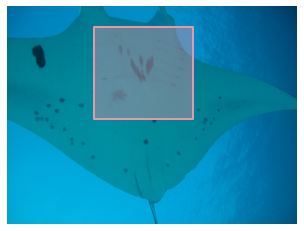

In [34]:
# load and display instance annotations
catIds = coco.getCatIds(catNms=nms);
imgIds = coco.getImgIds(catIds=catIds);

img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)
#anns